# Cartpole: A Comparison
This Mini-project's goal is to apply Deep Reinforcement Learning techniques to the Cart-Pole environment. We will implement DQN (REF) as well as improvements Double DQN, and Dueling DQN. The performance of all three will be compared on cartpole. This will hopefully act as a test bed for understanding various improvements.

### Open AI Gym
First I want to import Open AI gym and test that the cartpole environment will work. I will play a game with the policy that the left action will be chosen whenever the velocity of the pole is to the right and vice versa.

In [1]:
import tensorflow as tf
import numpy as np
import gym
import matplotlib.pyplot as plt
import random
%matplotlib inline

In [2]:
env = gym.make('CartPole-v1')
state = env.reset()
done = False
while not done:
    env.render()
    # This policy looks at the angular velocity (state[3]) and applies force in the opposite direction.
    # It is by no means a perfect policy but it is a decent test to ensure its working as expected
    action = 0 if (state[3] < 0) else 1
    state, reward, done, info = env.step(action)
    
env.render(close=True)

### Deep Q Learning (DQN)
The agent below implements DQN as presented in [REF]. Since CartPole is a simple game, The network will be implemented with only 2 hidden layers. The orignal DQN paper introduced two key ideas. 1) The replay-buffer which records (S,A,R,S') experiences and 2) The target of the Q learning (approximation of true Q value) is held fixed and periodically updated.

In order to implement 2) we need to create two identical networks and then copy operations for moving the parameters from one to the other.

In [3]:
# Replay Buffer Class by David Kroezen

from collections import deque

class ReplayBuffer:

    num_state = 3
    
    def __init__(self, buffer_size):
        " Initializes the replay buffer by creating a deque() and setting the size and buffer count. "
        self.buffer = deque()
        self.buffer_size = buffer_size
        self.count = 0
         
    def add(self, s, a, r, d, s2):
         
        """ Adds new experience to the ReplayBuffer(). If the buffer size is
        reached, the oldest item is removed.
         
        Inputs needed to create new experience:
            s      - State
            a      - Action
            r      - Reward
            d      - Done
            s2     - Resulting State     
        """
        d = 1 if d else 0
        # Create experience list
        experience = (s, a, r, d, s2)
        
        # Check the size of the buffer
        if self.count < self.buffer_size:
            self.count += 1
        else:
            self.buffer.popleft()
            
        # Add experience to buffer
        self.buffer.append(experience)
        
    def size(self):
        " Return the amount of stored experiences. " 
        return self.count
    
    def batch(self, batch_size):
        "Return a \"batch_size\" number of random samples from the buffer."
        
        if self.count < batch_size:
            batch = random.sample(self.buffer, self.count)
            batch_size = self.count
        else:
            batch = random.sample(self.buffer, batch_size)
            
        batch_state = np.array([item[0] for item in batch])#.reshape([batch_size,self.num_state])
        batch_action = np.array([item[1] for item in batch])#.reshape([batch_size, 1])
        batch_reward = np.array([item[2] for item in batch])#.reshape([batch_size, 1])
        batch_done = np.array([item[3] for item in batch])#.reshape([batch_size, 1])
        batch_next_state = np.array([item[4] for item in batch])#.reshape([batch_size,self.num_state])
        
        return batch_state, batch_action, batch_reward, batch_done, batch_next_state 
            
    def clear(self):
        " Remove all entries from the ReplayBuffer. "
        self.buffer.clear()
        self.count = 0

In [6]:
def makeDQN(state, h_size, a_size, name):
    # Make a network
    with tf.variable_scope(name):
        h1 = tf.nn.relu(tf.layers.dense(state, h_size))
        h2 = tf.nn.relu(tf.layers.dense(h1, h_size))
        out = tf.layers.dense(h2, a_size)
    return out

def copyVars(fromName, toName):
    # Constructs the copy operations
    fvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=fromName)
    tvars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES, scope=toName)
    
    copy = [tf.assign(t, f) for f, t in zip(fvars, tvars)]
    return copy
    

class DQN():
    def __init__(self, sess, e_size, h_size, a_size, lr=0.01, gamma=0.99, replay_length=10000, batch_size=64):
        
        # Store params
        self.batch_size = batch_size
        self.replay_length = replay_length
        self.sess = sess
        
        # Define Inputs
        self.state = tf.placeholder(tf.float32, shape=[None, e_size], name='State_input')
        self.actions = tf.placeholder(tf.int32, shape=[None], name='actions')
        self.rewards = tf.placeholder(tf.float32, shape=[None], name='rewards')
#         self.dones = tf.placeholder(tf.float32, shape=[None], name='dones')
        self.next_state = tf.placeholder(tf.float32, shape=[None, e_size], name='Next_State_input')
#         self.learning_rate = tf.placeholder(tf.float32)
        
        # Define Network
        self.main = makeDQN(self.state, h_size, a_size, 'main')
        self.target = makeDQN(self.next_state, h_size, a_size, 'target')
        
        # Create the update operations for updating the target network
        self.copy = copyVars('main', 'target')
        
        # Define the Loss operation 
        target = self.rewards + gamma*tf.reduce_max(self.target, axis=1)
        choice = tf.one_hot(self.actions, a_size)
        predicted = tf.reduce_max(self.main*choice)
        
        self.loss = tf.reduce_mean(tf.square(target-predicted))
        
        # Optimizer
        # Restrict training to the main network
        tvars = tf.trainable_variables(scope='main')
        self.optimize = tf.train.AdamOptimizer(lr).minimize(self.loss, var_list=tvars)
        
        # Helper ops
        self.choice = tf.argmax(self.main, 1)
        self.choice_prob = tf.nn.softmax(self.main)
        
        
        # Set up experience replay buffer
        self.replay = ReplayBuffer(replay_length)
        
    def train(self):
        # Get a batch of experiences
        states, actions, rewards, dones, next_states = self.replay.batch(self.batch_size)
        self.sess.run(self.optimize, feed_dict={self.state: states,
                                            self.actions: actions,
                                            self.rewards: rewards,
                                            self.next_state: next_states})
    def clean_state(self, s):
        # This really SHOULD convert to a numpy array also
        if (len(s.shape)==1):
            s = s[None, :]
        return s
    
    def remember(self, state, action, reward, done, next_state):
        self.replay.add(state, action, reward, done, next_state)
        
    def choose_action(self, state):
        return self.sess.run(self.choice, feed_dict={self.state: self.clean_state(state)})
    
    def choose_probs(self, state):
        return self.sess.run(self.choice_prob, feed_dict={self.state: self.clean_state(state)})
    
    def update_target(self):
#         print (self.sess.run(self.main, feed_dict={self.state:[[0.01,0.01,0.01,0.01]]}))
#         print (self.sess.run(self.target, feed_dict={self.next_state:[[0.01,0.01,0.01,0.01]]}))
        self.sess.run(self.copy)
#         print (self.sess.run(self.target, feed_dict={self.next_state:[[0.01,0.01,0.01,0.01]]}))
        
        

### Running DQN
With the agent defined its time to test it

Round:       0 	Epsilon:  1.00 	Test Score:   22.25
Round:     100 	Epsilon:  0.80 	Test Score:    9.47
Round:     200 	Epsilon:  0.68 	Test Score:    9.44
Round:     300 	Epsilon:  0.58 	Test Score:    9.56
Round:     400 	Epsilon:  0.50 	Test Score:    9.38
Round:     500 	Epsilon:  0.44 	Test Score:    9.38
Round:     600 	Epsilon:  0.39 	Test Score:    9.47
Round:     700 	Epsilon:  0.35 	Test Score:    9.44
Round:     800 	Epsilon:  0.31 	Test Score:    9.44
Round:     900 	Epsilon:  0.28 	Test Score:    9.69
Round:    1000 	Epsilon:  0.25 	Test Score:    9.22
Round:    1100 	Epsilon:  0.23 	Test Score:    9.34
Round:    1200 	Epsilon:  0.20 	Test Score:    9.41
Round:    1300 	Epsilon:  0.18 	Test Score:    9.28
Round:    1400 	Epsilon:  0.17 	Test Score:    9.41
Round:    1500 	Epsilon:  0.15 	Test Score:    9.31
Round:    1600 	Epsilon:  0.14 	Test Score:    9.41
Round:    1700 	Epsilon:  0.13 	Test Score:    9.12
Round:    1800 	Epsilon:  0.11 	Test Score:    9.62
Round:    19

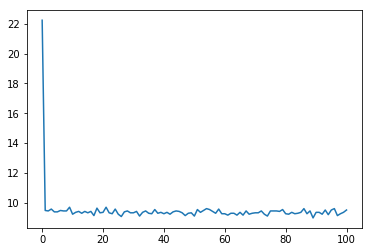

In [21]:
tf.reset_default_graph()

# Parameters
learning_rate = 0.0001
buffer_size = 10000
batch_size = 20
gamma = 0.99
hidden_layer = 64
# epsilon = 0.5

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

num_episodes = 10000
train_freq = 1
target_update_freq = 10000

report_freq = 100


env = gym.make('CartPole-v1')
# Environment Parameters
e_size = 4
a_size = 2


def test_player(player, env, runs=100):
    reward_sum = 0
    for i in range(runs):
        run_reward = 0
        state = env.reset()
        done = False
        t = 0.
        while not done:
            t += 1
            action = player.choose_action(state)[0]
            state, reward, done, info = env.step(action)
            run_reward += reward
            if done:
                reward_sum += run_reward
                break
        env.reset()
    return reward_sum/runs



step_count = 0
scores = []
sess = tf.Session()

# Create Agent
player = DQN(sess, e_size, hidden_layer, a_size, learning_rate, gamma, buffer_size, batch_size)

# Initialize 
sess.run(tf.global_variables_initializer())
player.update_target()

for i in range(num_episodes):
    state = env.reset()
    done = False
    t = 0
    while not done:
        step_count += 1
        t += 1
        # Epsilon greedy exploration policy
        epsilon = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step_count) 
        if (np.random.uniform() <= epsilon):
            action= np.random.choice(range(a_size))
        else:
            # Do a weighted sample to pick your action
            action_prob = player.choose_probs(state)[0]
#                 print (action_prob)
            action = np.random.choice(range(a_size), p=action_prob)

        new_state, reward, done, info = env.step(action)
#         reward = -1 if done else 0
        player.remember(state, action, reward, done, new_state)
        state = new_state

        if (step_count % train_freq == 0):
            player.train()

        if (step_count % target_update_freq == 0):
#             print ("updating target")
            player.update_target()

        if done:

            if (i % report_freq == 0 or i == num_episodes-1):
                score = test_player(player, env, runs=32)
                scores.append(score)
                print("Round: {0:7d} \tEpsilon: {1:5.2f} \tTest Score: {2:7.2f}".format(i, epsilon, score))

plt.plot(scores)
plt.show()